In [ ]:
'''A comprehensive pipeline for processing supermarket sales data,
including preprocessing, regression modeling, and customer segmentation.

This module provides a complete workflow for analyzing supermarket sales data through:
1. Data loading and initial exploration
2. Preprocessing (handling dates, categorical variables, missing values)
3. Regression modeling (comparing multiple models)
4. Customer segmentation using K-means clustering

Author: Ricson Ramos
Version: 1.1
Date: 31/10/2025
'''

'A comprehensive pipeline for processing supermarket sales data,\nincluding preprocessing, regression modeling, and customer segmentation.\n\nThis module provides a complete workflow for analyzing supermarket sales data through:\n1. Data loading and initial exploration\n2. Preprocessing (handling dates, categorical variables, missing values)\n3. Regression modeling (comparing multiple models)\n4. Customer segmentation using K-means clustering\n\nAuthor: Ricson Ramos\nVersion: 1.0\nDate: 31/10/2025\n'

In [1]:
# -----------------------------------------------------------------------
# IMPORTS
# -----------------------------------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
from datetime import datetime
from IPython.display import display

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from typing import Dict, Tuple, Optional

In [11]:
# -----------------------------------------------------------------------
# DATA LOADING AND EXPLORATION
# -----------------------------------------------------------------------

def load_dataset(path: str) -> pd.DataFrame:
    """Loads a CSV dataset and displays summary information."""
    try:
        df = pd.read_csv(path, low_memory=False)
    except FileNotFoundError:
        print(f"Erro: Arquivo não encontrado no caminho: {path}")
        return None
    except Exception as e:
        print(f"Erro ao carregar o arquivo CSV: {e}")
        return None

    with pd.option_context('display.max_rows', 3):
        display(df)

    print(f"\n=== SHAPE ===\nLinhas: {df.shape[0]}, Colunas: {df.shape[1]}")
    print("\n=== INFO ===")
    df.info()
    print("\n=== DESCRIBE ===")
    print(df.describe(include='all'))
    print("\n=== VALORES NULOS ===")
    print(df.isnull().sum())
    print("\n=== TIPOS DE DADOS ===")
    print(df.dtypes.value_counts())
    print(f"\nTotal de valores únicos no DataFrame: {df.nunique().sum()}")
    return df

In [3]:
# -----------------------------------------------------------------------
# PREPROCESSING
# -----------------------------------------------------------------------

def preprocess(df: pd.DataFrame, max_unique_for_dummies: int = 10) -> pd.DataFrame:
    """Preprocesses data (categorical encoding, missing values, date features)."""
    if df is None:
        print("DataFrame de entrada é None. Retornando.")
        return None

    df = df.copy()

    # --- Remove high-cardinality categorical columns ---
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    cat_cols_to_drop = [col for col in cat_cols if df[col].nunique() > max_unique_for_dummies]
    if cat_cols_to_drop:
        print(f"Colunas removidas (alta cardinalidade): {cat_cols_to_drop}")
        df = df.drop(columns=cat_cols_to_drop)

    # --- Encode categorical columns ---
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        n_unique = df[col].nunique()
        if n_unique <= max_unique_for_dummies:
            df = pd.get_dummies(df, columns=[col], prefix=col, drop_first=True)
            print(f"{col}: codificado com One-Hot Encoding ({n_unique} categorias)")
        else:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            print(f"{col}: codificado com LabelEncoder ({n_unique} categorias)")

    # --- Handle dates ---
    if 'Date' in df.columns:
        try:
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df['Year'] = df['Date'].dt.year
            df['Month'] = df['Date'].dt.month
            df['Day'] = df['Date'].dt.day
            df['Weekday'] = df['Date'].dt.weekday
            df.drop(columns=['Date'], inplace=True)
            print("'Date' convertida e features extraídas.")
        except Exception as e:
            print(f"Erro ao processar 'Date': {e}")

    if 'Time' in df.columns:
        try:
            df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
            df['Hour'] = df['Time'].dt.hour
            df['Minute'] = df['Time'].dt.minute
            df.drop(columns=['Time'], inplace=True)
            print("'Time' convertida e features extraídas.")
        except Exception as e:
            print(f"Erro ao processar 'Time': {e}")

    # --- Fill missing values ---
    df.fillna(df.mean(numeric_only=True), inplace=True)
    df.fillna('missing', inplace=True)

    print("\nPré-processamento completo!")
    return df

In [4]:
# -----------------------------------------------------------------------
# CORRELATION FILTER
# -----------------------------------------------------------------------

def remove_highly_correlated(df: pd.DataFrame, threshold: float = 0.9) -> pd.DataFrame:
    """Removes highly correlated numeric columns."""
    if df is None or df.empty:
        return df

    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) < 2:
        return df

    corr_matrix = df[numeric_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    if to_drop:
        print(f"Colunas removidas por alta correlação: {to_drop}")
        df = df.drop(columns=to_drop)
    return df

In [5]:
# -----------------------------------------------------------------------
# REGRESSION MODEL COMPARISON
# -----------------------------------------------------------------------

def compare_regression_models(
    df: pd.DataFrame,
    target: str,
    corr_threshold: float = 0.7
) -> Tuple[Optional[object], str, float, float, Dict[str, Dict[str, float]]]:
    """Compares regression models and returns the best one."""
    print(f"--- Comparando Modelos de Regressão para '{target}' ---")

    if df is None or target not in df.columns:
        raise ValueError("DataFrame inválido ou coluna alvo inexistente.")

    X = df.drop(columns=[target])
    y = df[target]
    X = remove_highly_correlated(X, threshold=corr_threshold)

    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(random_state=42)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)),
        ('GradientBoosting', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                                      max_depth=3, random_state=42))
    ]

    results = {}
    for name, model in models:
        scores = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1)
        results[name] = {'R2_CV_Medio': scores.mean(), 'R2_CV_Std': scores.std()}
        print(f"{name}: R² médio = {scores.mean():.4f} (+/- {scores.std():.4f})")

    best_model_name = max(results, key=lambda k: results[k]['R2_CV_Medio'])
    best_model = next(m for n, m in models if n == best_model_name)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    print(f"\nMelhor modelo: {best_model_name}")
    print(f"R² Teste: {r2_test:.4f}, MSE: {mse:.4f}")

    return best_model, best_model_name, r2_test, mse, results

In [6]:
# -----------------------------------------------------------------------
# SEGMENTATION (K-Means)
# -----------------------------------------------------------------------

def find_best_k(X_scaled, k):
    """Calcula o Silhouette Score para um valor de k."""
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    return k, score, labels

def segment_and_plot(df, max_clusters=10, random_state=42):
    """Performs K-Means segmentation and plots PCA 2D visualization."""
    print("--- Iniciando Segmentação K-Means ---")

    num_cols = df.select_dtypes(include=np.number).columns
    X = df[num_cols].copy()

    if X.shape[0] < 2:
        print("Poucas amostras para clustering.")
        return df, 0, None

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    best_score, best_k, best_labels = -1, 2, None
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        futures = {executor.submit(find_best_k, X_scaled, k): k for k in range(2, max_clusters + 1)}
        for future in concurrent.futures.as_completed(futures):
            k, score, labels = future.result()
            if score > best_score:
                best_score, best_k, best_labels = score, k, labels

    if best_labels is None:
        print("Segmentação não foi possível.")
        return df, 0, None

    df['Cluster'] = best_labels
    print(f"Número ótimo de clusters: {best_k} (Silhouette Score = {best_score:.4f})")

    final_model = KMeans(n_clusters=best_k, random_state=random_state, n_init=10)
    final_model.fit(X_scaled)

    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)
    df['PC1'] = components[:, 0]
    df['PC2'] = components[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=80)
    plt.title('Segmentação de Clientes (K-Means + PCA)')
    plt.show()

    print("\nEstatísticas médias por cluster:")
    display(df.groupby('Cluster')[num_cols].mean())

    return df, best_k, final_model

In [7]:
# -----------------------------------------------------------------------
# MAIN PROCESS
# -----------------------------------------------------------------------

def process(df: pd.DataFrame, target_column: str = 'Sales') -> dict:
    """Executes full pipeline: preprocessing → regression → segmentation."""
    if df is None:
        print("Processo abortado: DataFrame de entrada é None.")
        return None

    print("=====================================================")
    print("============= INICIANDO PROCESSO GERAL ==============")
    print("=====================================================")

    df_processed = preprocess(df)

    # Regressão
    if target_column in df_processed.columns:
        best_model, model_name, r2_test, mse_test, history = compare_regression_models(
            df_processed, target=target_column
        )
    else:
        print(f"Coluna alvo '{target_column}' não encontrada. Regressão ignorada.")
        best_model, model_name, r2_test, mse_test, history = None, None, None, None, {}

    # Segmentação
    df_segmented, optimal_k, kmeans_model = segment_and_plot(df_processed)

    # Gera relatório
    with open(f"report_{datetime.now().strftime('%Y-%m-%d_%H-%M')}.txt", "w", encoding="utf-8") as f:
        f.write(
            f"""
Relatório de Desempenho - Supermarket Sales
--------------------------------------------

Modelo escolhido: {model_name}
R² no teste: {r2_test}
MSE: {mse_test}

Número ótimo de clusters: {optimal_k}
"""
        )

    print("================== PROCESSO CONCLUÍDO ==================")
    return {
        'df_results': df_segmented,
        'best_regression_model': best_model,
        'best_model_name': model_name,
        'regression_metrics': {
            'R2_Teste': r2_test,
            'MSE_Teste': mse_test,
            'Histórico_CV': history
        },
        'segmentation_model': kmeans_model,
        'optimal_k': optimal_k,
    }



,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,849-09-3807,Alex,Yangon,Member,Female,Fashion accessories,88.34,7,30.9190,649.2990,2/18/2019,1:28:00 PM,Cash,618.38,4.761905,30.9190,6.6



=== SHAPE ===
Linhas: 1000, Colunas: 17

=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Sales                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                    

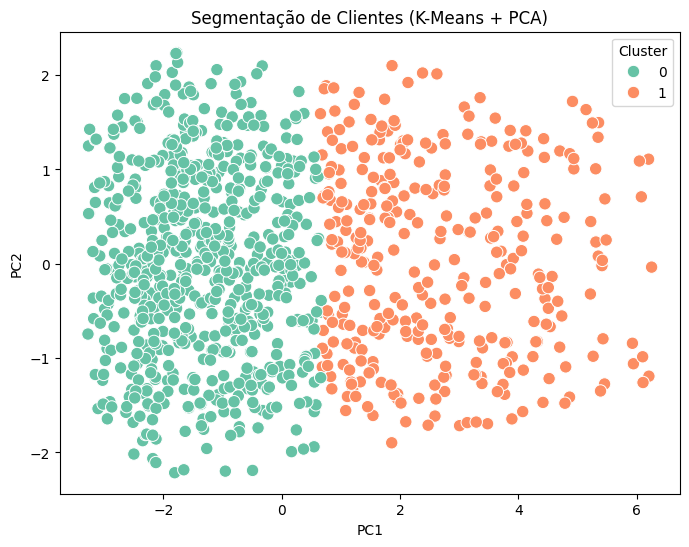


Estatísticas médias por cluster:


,Unit price,Quantity,Tax 5%,Sales,cogs,gross margin percentage,gross income,Rating
Cluster,,,,,,,,
0,45.297447,4.325826,8.307023,174.447473,166.140450,4.761905,8.307023,7.000300
1,76.359371,7.871257,29.481713,619.115964,589.634251,4.761905,29.481713,6.917665


================== PROCESSO CONCLUÍDO ==================


In [12]:
# -----------------------------------------------------------------------
# EXECUTION EXAMPLE
# -----------------------------------------------------------------------

if __name__ == '__main__':
    path = r'D:\Documentos\VsCode\projetos_git\supermarket sales\data\SuperMarket Analysis.csv'
    df = load_dataset(path)
    results = process(df, target_column='Sales')
